In [98]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from inverseSD import inverseSD
from IPython.display import display

from PIL import Image, ImageColor

In [99]:
def UnetWrapperSaveAttn(unet):
    class NewAttnProcessor:
        r"""
        Processor for performing attention-related computations.
        Save attention map
        """
    
        def __call__(
            self,
            attn,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None,
            temb=None,
        ):
            residual = hidden_states
    
            if attn.spatial_norm is not None:
                hidden_states = attn.spatial_norm(hidden_states, temb)

            input_ndim = hidden_states.ndim
    
            if input_ndim == 4:
                batch_size, channel, height, width = hidden_states.shape
                hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
    
            batch_size, sequence_length, dim = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
    
            if attn.group_norm is not None:
                hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)
    
            query = attn.to_q(hidden_states)
    
            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            elif attn.norm_cross:
                encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)
    
            key = attn.to_k(encoder_hidden_states)
            value = attn.to_v(encoder_hidden_states)

            query = attn.head_to_batch_dim(query)
            key = attn.head_to_batch_dim(key)
            value = attn.head_to_batch_dim(value)


            attention_probs = attn.get_attention_scores(query, key, attention_mask)

            n_heads = len(attention_probs) // batch_size
            self.attention_probs = attention_probs.reshape(batch_size, n_heads, *attention_probs.shape[-2:])

            hidden_states = torch.bmm(attention_probs, value)
            hidden_states = attn.batch_to_head_dim(hidden_states)
    
            # linear proj
            hidden_states = attn.to_out[0](hidden_states)
            # dropout
            hidden_states = attn.to_out[1](hidden_states)
    
            if input_ndim == 4:
                hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)
    
            if attn.residual_connection:
                hidden_states = hidden_states + residual
    
            hidden_states = hidden_states / attn.rescale_output_factor
    
            return hidden_states

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention":
            module.processor = NewAttnProcessor()

    return unet

In [100]:
device = torch.device('cuda')

In [101]:
model_path = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16, use_auth_token=True).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()


In [102]:
pipe.unet = UnetWrapperSaveAttn(pipe.unet)

In [103]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device=device)
seed = 10 #@param {type:"number"}
g_cuda.manual_seed(seed)

In [121]:
import torch.nn.functional as F

class AttnMap():
    def __init__(self):
        self.self_attnmap_per_i = {}
        self.cross_attnmap_per_i = {}
    
    @torch.no_grad()
    def get_attnmap(self, i, t, latents):
        self_attnmap_list = []
        cross_attnmap_list = []
        
        for name, module in pipe.unet.named_modules():
            module_name = type(module).__name__
            if module_name == "Attention":
                if "attn1" in name:
                    self_attnmap_list.append(module.processor.attention_probs.cpu())
                elif "attn2" in name:
                    cross_attnmap_list.append(module.processor.attention_probs.cpu())
            
        self.cross_attnmap_per_i[i] = cross_attnmap_list
        self.self_attnmap_per_i[i] = self_attnmap_list

    def get_average_attnmap(self, step_idx, token_idx, img_idx, type='cross'):
        n_imgs = len(self.cross_attnmap_per_i[step_idx]) // 2
        if type == 'cross':
            attnmaps = self.cross_attnmap_per_i[step_idx][n_imgs+img_idx]
        elif type == 'self':
            attnmaps = self.self_attnmap_per_i[step_idx][n_imgs+img_idx]
        
        attnmap_list = []
        for attnmap in attnmaps:
            res = int(np.sqrt(attnmap.shape[-2]))
            attnmap = torch.index_select(attnmap, -1, torch.tensor(token_idx)).mean(0).squeeze().view(1, 1, res, res).float()
            attnmap = F.interpolate(attnmap, size=(512, 512), mode="nearest").squeeze()
            attnmap_list.append(attnmap)
        attnmap_avg = torch.stack(attnmap_list, 0).mean(0)
        return attnmap_avg

    def visualize_attnmap(self, image, attnmap):
        # Normalize the attention heatmap to values between 0 and 1
        attnmap = np.array(attnmap)
        normalized_heatmap = (attnmap - attnmap.min()) / (attnmap.max() - attnmap.min())
    
        # Apply color mapping to create a heatmap image
        # In this example, we'll use a red color map, but you can change it as needed.
        color_map = ImageColor.getcolor('red', 'RGBA')
        heatmap_image = Image.fromarray((normalized_heatmap * 255).astype(np.uint8)).convert('L')
        heatmap_image = heatmap_image.convert('RGBA')
        heatmap_image.putalpha(128)  # Adjust the transparency of the heatmap
    
        # Overlay the heatmap on the original image
        blended_image = Image.alpha_composite(image.convert('RGBA'), heatmap_image)
        
        # Save or display the final visualization
        # blended_image.show()
    
        return blended_image

In [134]:
# Generate images

prompt = "a photo of dog in a bucket" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
callback_steps = 12
attnmap = AttnMap()

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda,
        callback=attnmap.get_attnmap,
        callback_steps=callback_steps
    ).images

# for img in images:
#     display(img)

100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


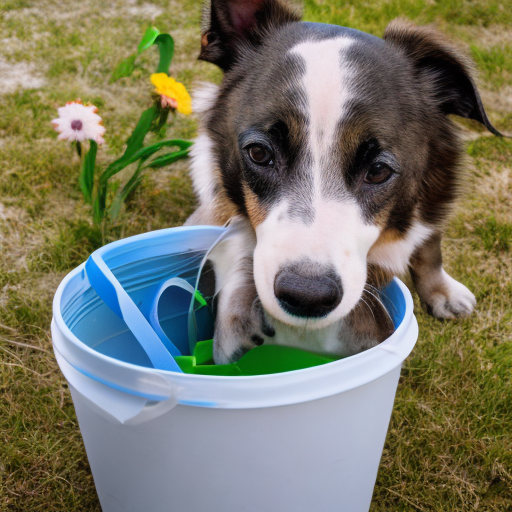

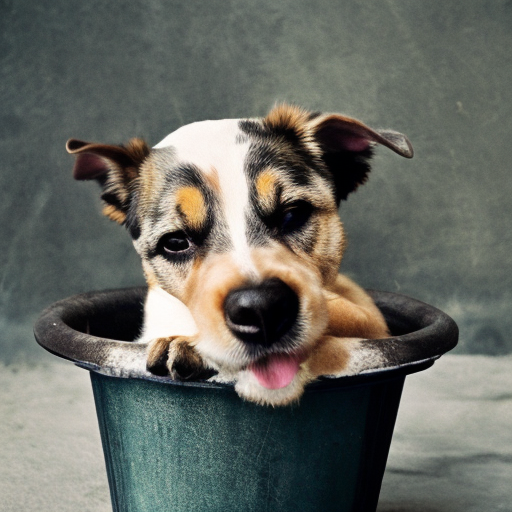

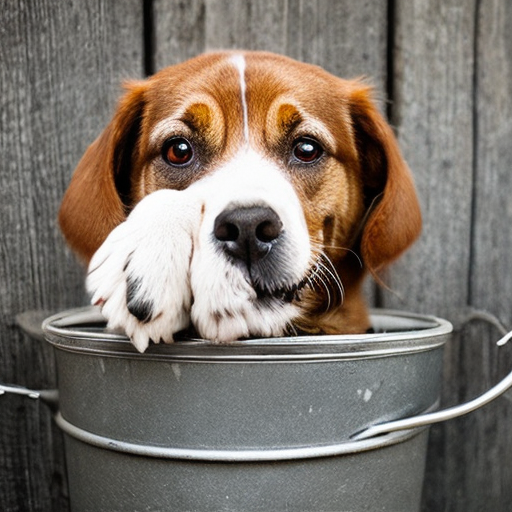

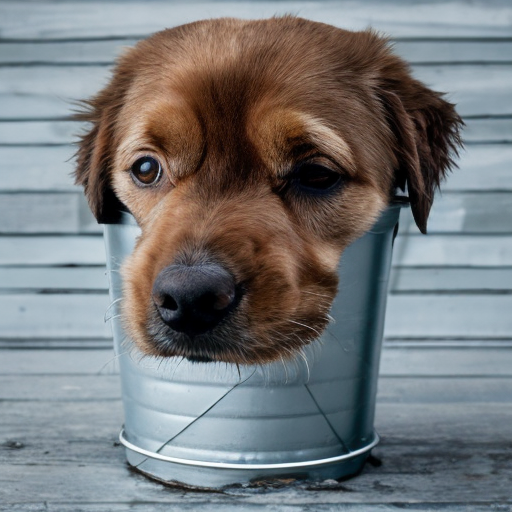

In [135]:
for img in images:
    display(img)

In [149]:
img_idx = 0

attention_map = attnmap.get_average_attnmap(
    token_idx=7 , # bucket
    img_idx=img_idx,
    step_idx=callback_steps
)

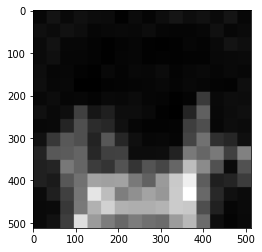

In [150]:
import matplotlib.pyplot as plt
plt.imshow(attention_map, cmap='gray')

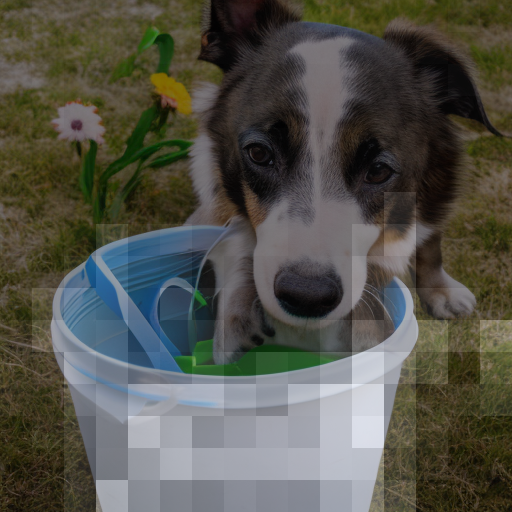

In [151]:
attn_map.visualize_attnmap(images[img_idx], attention_map)